In [1]:
import torch
from torch.autograd import Variable
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns


np.random.seed(42)



In [2]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
epochs = 10000

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
device

device(type='cuda', index=0)

In [6]:
from models import GPUModel

In [7]:
N = 100


In [8]:


def generate_data(datalen=1000,noise_level=0.2,padding_size=10) -> np.array:
    """returns numpy arrays X and y that can be used as basis for regression problem"""
    
    X_long = np.linspace(0,1,datalen)
    X = X_long[padding_size:]
    X = X[:len(X) - padding_size]  
    

    #X = np.arange(0, self.datalen)
    #X = np.linspace(0,300,datalen)
    
    #padding = datalen/2
    X = np.insert(X,0,X_long[0])
    X = np.append(X,X_long[-1])
    #X_long = np.append(X_long,np.max(X)+padding)

    freq1 = 0.2
    freq2 = 0.15

    freq1 = 0.1
    freq2 = 0.0375
    noise = np.random.randn(len(X)) * noise_level
    
    def generate_y(X_):
        """nonlinear case"""
        X_ = X_ * 200
        y1 = np.sin(X_ * freq1) 
        y2 = np.sin(X_ * freq2) 
        return y1 + y2
    
    def generate_y_linear(X_):
        """linear case"""
        return X_/datalen
    
    y = generate_y(X) + noise
    y_long = generate_y(X_long)
    
    #X = (X - np.min(X_long)) / (np.max(X_long) - np.min(X_long))
    #X_long = (X_long - np.min(X_long)) / (np.max(X_long) - np.min(X_long))
    

    #return np.expand_dims(X.astype(np.float32),1), np.expand_dims(y.astype(np.float32),1), X_long, y_long
    #data_utils.TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(Y).float())

    return X, y, X_long, y_long

In [9]:
#[np.random.randn() for x in range(100)]

In [10]:
X_np,y_np,X_long_np,y_long_np = generate_data(N,0.3)

In [11]:
X = torch.tensor(X_np, requires_grad=False, dtype=torch.float).unsqueeze(1)
y = torch.tensor(y_np, requires_grad=False, dtype=torch.float).unsqueeze(1)

X_long = torch.tensor(X_long_np, requires_grad=False, dtype=torch.float).unsqueeze(1)
y_long = torch.tensor(y_long_np, requires_grad=False, dtype=torch.float).unsqueeze(1)


In [12]:
X[:10]

tensor([[0.0000],
        [0.1010],
        [0.1111],
        [0.1212],
        [0.1313],
        [0.1414],
        [0.1515],
        [0.1616],
        [0.1717],
        [0.1818]])

In [13]:


X = X.to(device=device)
y = y.to(device=device)


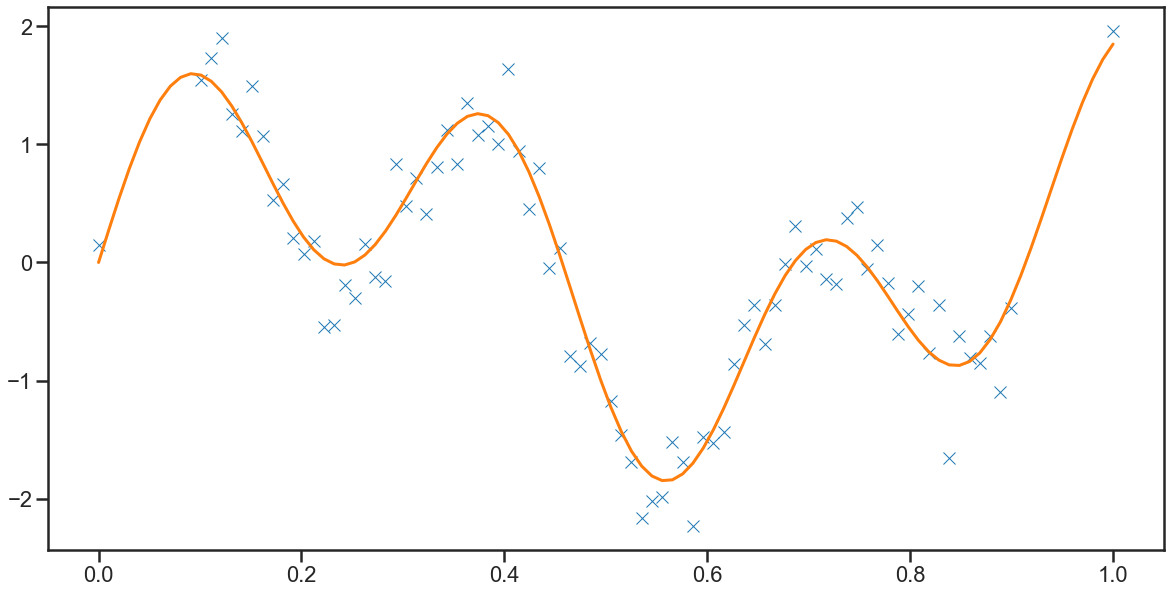

In [14]:
plt.plot(X_np,y_np,'x')
plt.plot(X_long_np,y_long_np)

In [15]:
model = GPUModel()
model = model.to(device)
model.float()


GPUModel(
  (criterion): MSELoss()
  (f): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05000000074505806, inplace=False)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05000000074505806, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.05000000074505806, inplace=False)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [16]:
torch.cuda.synchronize()


In [17]:
torch.cuda.is_available()

True

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 205.75it/s]


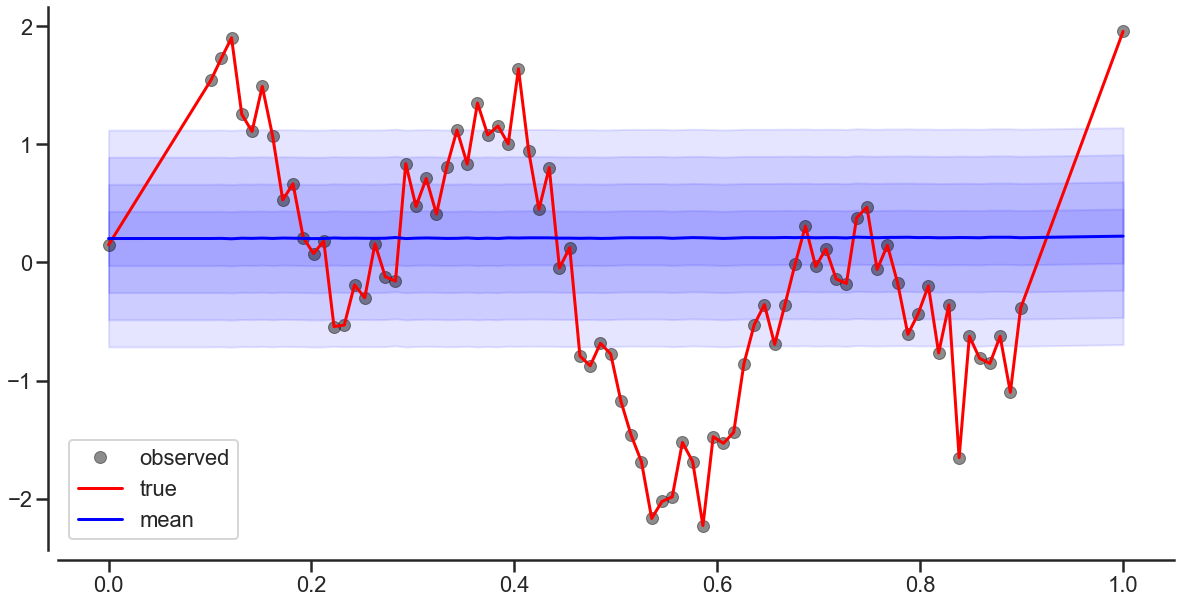

In [18]:

iters = 100
l2 = 1
n_std = 4


fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X, iters, l2=l2)
#y_mean, y_std = ensemble_uncertainity_estimate(model,X,iters,l2=l2)
    
ax.plot(X_np, y_np, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_np, y_np, ls="-", color="r", label="true")
ax.plot(X_np, y_mean, ls="-", color="b", label="mean")

for i in range(n_std):
    ax.fill_between(
        X_np.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
ax.legend()
sns.despine(offset=10)


In [19]:

%%time

for i in range(epochs):
    X = X.to(device=device)
    y = y.to(device)

    model.fit_model(X,y)

Wall time: 1min 16s


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 546.45it/s]


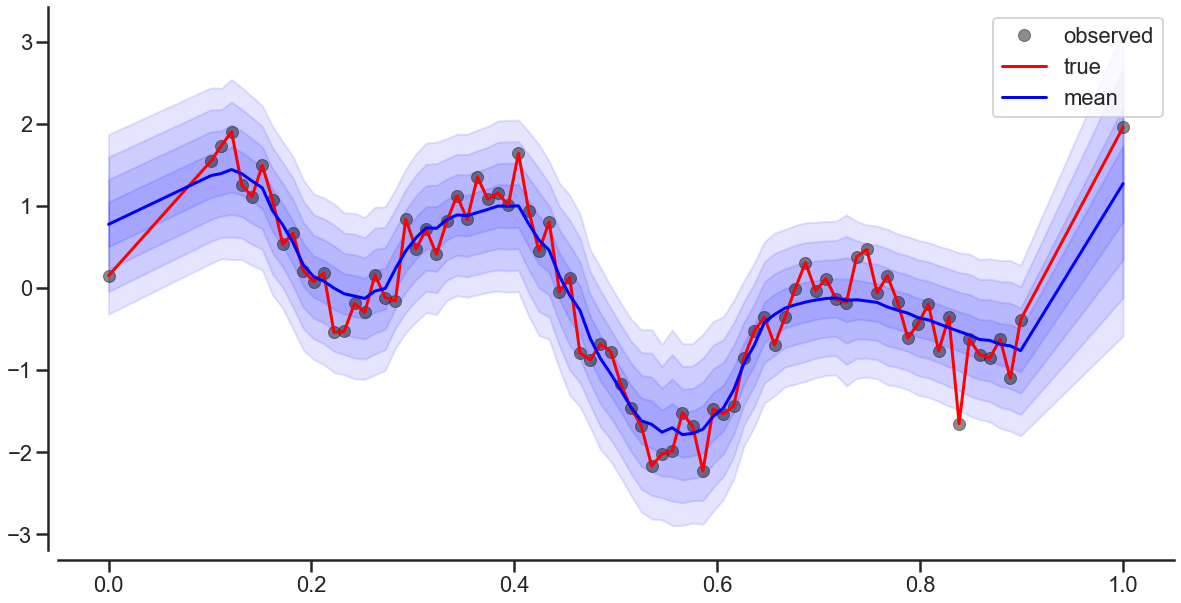

In [20]:

iters = 100
l2 = 1
n_std = 4


fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X, iters, l2=l2)
#y_mean, y_std = ensemble_uncertainity_estimate(model,X,iters,l2=l2)
    
ax.plot(X_np, y_np, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_np, y_np, ls="-", color="r", label="true")
ax.plot(X_np, y_mean, ls="-", color="b", label="mean")

for i in range(n_std):
    ax.fill_between(
        X_np.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
ax.legend()
sns.despine(offset=10)